# 1. IMPORT DATASETS AND LIBRARIES


In [23]:
import pandas as pd
import plotly.express as px
from copy import copy
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import plotly.figure_factory as ff
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tensorflow import keras


In [24]:
!pip install yfinance --upgrade --no-cache-dir -q

In [25]:
from pandas_datareader import data as pdr
import yfinance as yf
from datetime import datetime, timedelta

yf.pdr_override() # download data faster

start_date = '2010-01-01'
today_date = datetime.today().strftime('%Y-%m-%d')
print('Today\'s date: ', today_date)
tomorrow_date = (datetime.today() + timedelta(days=1)).strftime('%Y-%m-%d')

# download dataframe
ticker = "BRK-B"
raw_price_df = pdr.get_data_yahoo(ticker, start = start_date, end = tomorrow_date)

Today's date:  2023-08-21
[*********************100%%**********************]  1 of 1 completed


In [26]:
# Sort the data based on Date
price_df_sorted = raw_price_df.sort_values(by = ['Date'])
price_df_sorted

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,66.000000,66.500000,65.919998,66.220001,66.220001,1575000
2010-01-05,66.389999,66.589996,66.150002,66.540001,66.540001,1310000
2010-01-06,66.500000,66.500000,66.199997,66.199997,66.199997,1760000
2010-01-07,66.199997,66.510002,66.139999,66.459999,66.459999,1505000
2010-01-08,66.480003,66.480003,66.300003,66.440002,66.440002,1500000
...,...,...,...,...,...,...
2023-08-14,358.250000,358.950012,356.809998,358.480011,358.480011,1990700
2023-08-15,357.000000,357.920013,353.670013,354.500000,354.500000,2863700
2023-08-16,354.600006,358.720001,353.380005,354.109985,354.109985,2196100


In [27]:
price_df_sorted.shape

(3430, 6)

# 2. PERFORM EXPLORATORY DATA ANALYSIS AND VISUALIZATION

In [28]:
# Check if Null values exist in stock prices data
price_df_sorted.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [29]:
# Get stock prices dataframe info
price_df_sorted.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3430 entries, 2010-01-04 to 2023-08-18
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3430 non-null   float64
 1   High       3430 non-null   float64
 2   Low        3430 non-null   float64
 3   Close      3430 non-null   float64
 4   Adj Close  3430 non-null   float64
 5   Volume     3430 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 187.6 KB


In [30]:
price_df_sorted.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3430.000000,3430.000000,3430.000000,3430.000000,3430.000000,3.430000e+03
mean,171.499213,172.628195,170.205012,171.468892,171.468892,4.509240e+06
std,76.886810,77.457292,76.231857,76.857590,76.857590,6.056351e+06
min,65.519997,66.199997,64.720001,64.940002,64.940002,6.720000e+04
25%,111.809998,112.457499,111.012501,111.555000,111.555000,3.090700e+06
50%,150.950005,151.635002,150.035004,150.699997,150.699997,3.828450e+06
75%,214.297501,215.577496,212.532494,214.147503,214.147503,4.919175e+06
max,364.200012,364.630005,358.850006,363.730011,363.730011,3.161342e+08


In [31]:
# price_df_sorted.filter(['Close'])

In [32]:
price_df = price_df_sorted.reset_index()[['Date', 'Close']]
price_df

,Date,Close
0,2010-01-04,66.220001
1,2010-01-05,66.540001
2,2010-01-06,66.199997
3,2010-01-07,66.459999
4,2010-01-08,66.440002
...,...,...
3425,2023-08-14,358.480011
3426,2023-08-15,354.500000
3427,2023-08-16,354.109985
3428,2023-08-17,353.190002


In [33]:
# Function to normalize stock prices based on their initial price
def normalize(df):
  x = df.copy()
  for i in x.columns[1:]:
    x[i] = x[i]/x[i][0]
  return x

In [34]:
# Function to plot interactive plots using Plotly Express
def interactive_plot(fig, df):
  for i in df.columns:
    if i != 'Date':
      fig.add_scatter(x = df['Date'], y = df[i], name = i)

In [35]:
# plot interactive chart for stocks data
import plotly.graph_objs as go

# create initial figure object
original_price_fig = go.Figure()
original_price_fig.update_layout(title = f'{ticker}Stock Price History', xaxis_title = 'Date', yaxis_title = 'Close Price USD ($)')

# plot initial data
interactive_plot(original_price_fig, price_df)
original_price_fig.show()


# 3. PREPARE THE DATA BEFORE TRAINING THE AI/ML MODEL

### Convert the dataframe into array format

In [36]:
# # filter dataframe based on date
# filtered_df = price_df.loc[price_df['Date'] >= '2021-05-28']
# filtered_df

In [37]:
price_df

,Date,Close
0,2010-01-04,66.220001
1,2010-01-05,66.540001
2,2010-01-06,66.199997
3,2010-01-07,66.459999
4,2010-01-08,66.440002
...,...,...
3425,2023-08-14,358.480011
3426,2023-08-15,354.500000
3427,2023-08-16,354.109985
3428,2023-08-17,353.190002


In [38]:
price_array = np.array(price_df['Close']).reshape(-1,1)
price_array.shape

(3430, 1)

### Splitting the dataset into the Training set and Test set

In [39]:
# splitting dataset into train and test split this way, since order is important in time-series
# dont use train test split with it's default settings since it shuffles the data
def split_X_train_test(X, test_size=0.2):
  split = int((1-test_size) * len(X)) # round up the number
  X_train = X[:split]
  X_test = X[split:]

  return X_train, X_test

X_train_unscaled, X_test_unscaled = split_X_train_test(price_array, 0.01)

### Time steps

In [40]:
time_steps = 60

### Add time steps for first X_test input

In [41]:
X_train_len = X_train_unscaled.shape[0]

In [42]:
X_train_unscaled.shape, X_test_unscaled.shape

((3395, 1), (35, 1))

In [43]:
X_train_unscaled[-1], X_test_unscaled[0]

(array([336.91000366]), array([341.]))

In [44]:
X_test_unscaled = np.concatenate((X_train_unscaled[-time_steps:], X_test_unscaled), axis=0)

In [45]:
X_test_unscaled.shape, X_test_unscaled[time_steps-1:time_steps+1]

((95, 1),
 array([[336.91000366],
        [341.        ]]))

### Feature Scaling for NN


In [46]:
# LSTM are sensitive to the scale of the data. so we apply MinMax scaler (output = np.array format)
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
X_train_scaled = sc.fit_transform(X_train_unscaled)
X_test_scaled = sc.transform(X_test_unscaled)

In [47]:
X_train_scaled, X_train_scaled.shape

(array([[0.00434443],
        [0.00543053],
        [0.00427653],
        ...,
        [0.91776122],
        [0.91372225],
        [0.92308997]]),
 (3395, 1))

In [48]:
X_test_scaled, X_test_scaled.shape

(array([[0.82859858],
        [0.8330788 ],
        [0.84027425],
        [0.84064755],
        [0.84431323],
        [0.84719812],
        [0.85907742],
        [0.86481344],
        [0.87855956],
        [0.88141058],
        [0.87618365],
        [0.87866137],
        [0.88039229],
        [0.88623012],
        [0.88042626],
        [0.8674948 ],
        [0.88684114],
        [0.89471534],
        [0.90021385],
        [0.88558524],
        [0.8766249 ],
        [0.86569594],
        [0.87886501],
        [0.88653568],
        [0.88222512],
        [0.87584422],
        [0.87465638],
        [0.87414718],
        [0.87767706],
        [0.87842376],
        [0.89077829],
        [0.89882226],
        [0.90096055],
        [0.89668397],
        [0.8762515 ],
        [0.86637479],
        [0.86236969],
        [0.86773241],
        [0.87312899],
        [0.8693615 ],
        [0.87628547],
        [0.89787192],
        [0.89481716],
        [0.91121066],
        [0.91803281],
        [0

### Creating the datasets with timesteps input

In [49]:
import numpy as np

# convert an array of values into a dataset matrix
def create_dataset(array_data, time_steps=1):

  X, y = [], [] # become a list

  for i in range(time_steps, len(array_data)):
      X.append(array_data[i-time_steps:i, 0]) # its a 2D array => [row, col]
      y.append(array_data[i, 0])

  # return the new dataset
  return np.array(X), np.array(y) # convert into np array for RNN inputs

X_train, y_train = create_dataset(X_train_scaled, time_steps)
X_test, y_test = create_dataset(X_test_scaled, time_steps)

In [50]:
X_train.shape, y_train.shape

((3335, 60), (3335,))

In [51]:
X_test.shape, y_test.shape

((35, 60), (35,))

### Reshaping to 3D tensor for RNN input format

In [52]:
  # RNN input params = (batch size, timesteps, features/indicators)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) # add a new dimensionality to be compatible with the 3D tensor input shape of RNN and allow more indicators
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [53]:
X_train.shape, y_train.shape

((3335, 60, 1), (3335,))

In [54]:
X_test.shape, y_test.shape

((35, 60, 1), (35,))

# 4. Building and Training the RNN

### load the model from google drive

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
# from tensorflow.keras.models import load_model

# model = load_model('/content/drive/MyDrive/Projects/Stock Trend Prediction/best_model.h5')

In [59]:

from keras.models import Sequential # allow us to build a NN object representing a sequence of layers
from keras.layers import Dense # add the output layer
from keras.layers import LSTM # add the LSTM layers
from keras.layers import Dropout # add dropout regularization

In [60]:
# Create the model
model = Sequential() # regression -- predicting continuous values
model.add(LSTM(units = 150, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units = 150, return_sequences = True))
model.add(Dropout(0.3))
model.add(LSTM(units = 150))
model.add(Dense(units = 1)) # dense class to create the fully-connected layer to fully connect the previous LSTM layer to one output unit

model.compile(optimizer='adam', loss="mean_squared_error")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 150)           91200     
                                                                 
 dropout (Dropout)           (None, 60, 150)           0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 150)           180600    
                                                                 
 dropout_1 (Dropout)         (None, 60, 150)           0         
                                                                 
 lstm_2 (LSTM)               (None, 150)               180600    
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                                 
Total params: 452,551
Trainable params: 452,551
Non-trai

In [61]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', verbose=1, patience=20)
file_path = f'/content/drive/MyDrive/Projects/Stock Trend Prediction/{ticker}_model.h5'
mc = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True)

# fit model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=64, callbacks=[es, mc])

Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 0.0080
Epoch 1: val_loss improved from inf to 0.00132, saving model to /content/drive/MyDrive/Projects/Stock Trend Prediction/BRK-B_model.h5
42/42 [==============================] - 37s 621ms/step - loss: 0.0080 - val_loss: 0.0013
Epoch 2/100
42/42 [==============================] - ETA: 0s - loss: 4.1491e-04
Epoch 2: val_loss did not improve from 0.00132
42/42 [==============================] - 26s 623ms/step - loss: 4.1491e-04 - val_loss: 0.0031
Epoch 3/100
42/42 [==============================] - ETA: 0s - loss: 3.4436e-04
Epoch 3: val_loss did not improve from 0.00132
42/42 [==============================] - 26s 620ms/step - loss: 3.4436e-04 - val_loss: 0.0021
Epoch 4/100
42/42 [==============================] - ETA: 0s - loss: 3.4539e-04
Epoch 4: val_loss did not improve from 0.00132
42/42 [==============================] - 29s 690ms/step - loss: 3.4539e-04 - val_loss: 0.0035
Epoch 5/100
42/42 [==================

dict_keys(['loss', 'val_loss'])


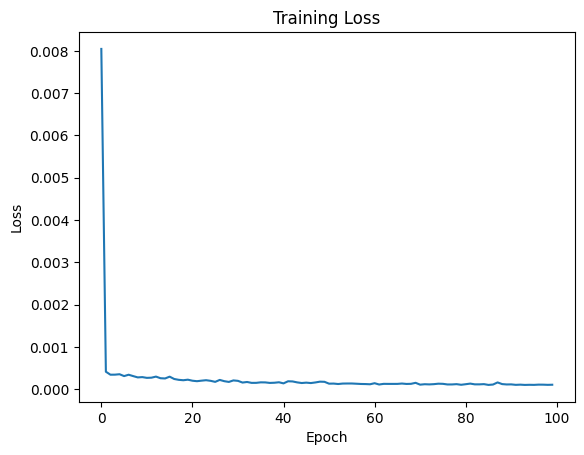

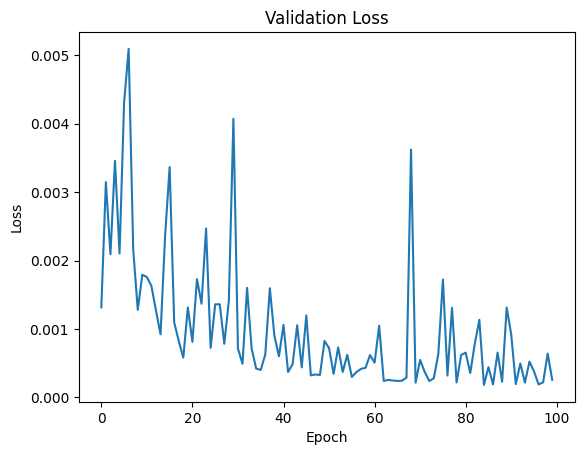

In [62]:
print(history.history.keys())

# Plot the training loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot the validation loss
plt.plot(history.history['val_loss'])
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [63]:
train_accuracy = model.evaluate(X_train, y_train, verbose=1)
print('train accuracy: ', train_accuracy)
test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print('test accuracy: ', test_accuracy)

105/105 [==============================] - 14s 134ms/step - loss: 9.8077e-05
train accuracy:  9.807704191189259e-05
2/2 [==============================] - 0s 30ms/step - loss: 4.1047e-04
test accuracy:  0.00041046805563382804


### Hyperparameter Tuning

In [64]:
# import tensorflow as tf
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# import itertools


# def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test):

#     first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = config
#     possible_combinations = list(itertools.product(first_additional_layer, second_additional_layer, third_additional_layer,
#                                                   n_neurons, n_batch_size, dropout))

#     print(possible_combinations)
#     print('\n')

#     hist = []

#     for i in range(0, len(possible_combinations)):

#         print(f'{i+1}th combination: \n')
#         print('--------------------------------------------------------------------')

#         first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = possible_combinations[i]

#         # instantiating the model in the strategy scope creates the model on the TPU
#         #with tpu_strategy.scope():
#         regressor = Sequential()
#         regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
#         regressor.add(Dropout(dropout))

#         if first_additional_layer:
#             regressor.add(LSTM(units=n_neurons, return_sequences=True))
#             regressor.add(Dropout(dropout))

#         if second_additional_layer:
#             regressor.add(LSTM(units=n_neurons, return_sequences=True))
#             regressor.add(Dropout(dropout))

#         if third_additional_layer:
#             regressor.add(LSTM(units=n_neurons, return_sequences=True))
#             regressor.add(Dropout(dropout))

#         regressor.add(LSTM(units=n_neurons, return_sequences=False))
#         regressor.add(Dropout(dropout))
#         regressor.add(Dense(units=1, activation='linear'))
#         regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

#         es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
#         '''''
#         From the mentioned article above --> If a validation dataset is specified to the fit() function via the validation_data or v
#         alidation_split arguments,then the loss on the validation dataset will be made available via the name “val_loss.”
#         '''''

#         file_path = '/content/drive/MyDrive/Projects/Stock Trend Prediction/best_model.h5'

#         mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

#         '''''
#         cb = Callback(...)  # First, callbacks must be instantiated.
#         cb_list = [cb, ...]  # Then, one or more callbacks that you intend to use must be added to a Python list.
#         model.fit(..., callbacks=cb_list)  # Finally, the list of callbacks is provided to the callback argument when fitting the model.
#         '''''

#         regressor.fit(x_train, y_train, validation_split=0.2, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)

#         # load the best model
#         # regressor = load_model('best_model.h5')

#         train_accuracy = regressor.evaluate(x_train, y_train, verbose=0)
#         test_accuracy = regressor.evaluate(x_test, y_test, verbose=0)

#         hist.append(list((first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout,
#                           train_accuracy, test_accuracy)))

#         print(f'{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}')

#         print('--------------------------------------------------------------------')
#         print('--------------------------------------------------------------------')
#         print('--------------------------------------------------------------------')
#         print('--------------------------------------------------------------------')

#     return hist

In [65]:
# config = [[False, True], [False, True], [False, True], [16, 32], [8, 16, 32], [0.2]]

# # list of lists --> [[first_additional_layer], [second_additional_layer], [third_additional_layer], [n_neurons], [n_batch_size], [dropout]]

# hist = LSTM_HyperParameter_Tuning(config, X_train, y_train, X_test, y_test)  # change x_train shape

In [66]:
# hist = pd.DataFrame(hist)
# hist = hist.sort_values(by=[7], ascending=True)
# hist

# 5. Plot the predictions

In [67]:
# Make prediction
scaled_predictions = model.predict(X_test)

2/2 [==============================] - 1s 26ms/step


In [68]:
predictions_array = sc.inverse_transform(scaled_predictions)
predictions_array.shape

(35, 1)

In [69]:
y_test = sc.inverse_transform(y_test.reshape(-1,1))

In [70]:
predictions_array.reshape(-1).shape, y_test.reshape(-1).shape

((35,), (35,))

In [71]:
# Get the RMSE
rmse = np.sqrt(((predictions_array - y_test) ** 2).mean())
rmse

5.969203170167153

In [72]:
# Append the predicted values to the list
predictions_list = []

for i in predictions_array:
  predictions_list.append(i[0])

len(predictions_list)

35

In [73]:
train_df = price_df[:X_train_len]
train_df = train_df.rename(columns={'Close': 'Previous Prices'})

valid_df = price_df[X_train_len:]
valid_df = valid_df.rename(columns={'Close': 'Actual Closing Price'})
valid_df['Next Day Prediction'] = predictions_list

In [74]:
valid_df

,Date,Actual Closing Price,Next Day Prediction
3395,2023-06-30,341.000000,332.048065
3396,2023-07-03,342.000000,335.140533
3397,2023-07-05,341.559998,337.069336
3398,2023-07-06,341.459991,337.336212
3399,2023-07-07,340.899994,337.169464
3400,2023-07-10,341.130005,336.734009
3401,2023-07-11,343.369995,336.712799
3402,2023-07-12,345.350006,338.151703
3403,2023-07-13,343.540009,340.094177
3404,2023-07-14,341.089996,339.779602


In [75]:
train_df

,Date,Previous Prices
0,2010-01-04,66.220001
1,2010-01-05,66.540001
2,2010-01-06,66.199997
3,2010-01-07,66.459999
4,2010-01-08,66.440002
...,...,...
3390,2023-06-23,335.250000
3391,2023-06-26,334.119995
3392,2023-06-27,335.339996
3393,2023-06-28,334.149994


In [76]:
# Plot the data
prediction_fig = go.Figure()
prediction_fig.update_layout(title = f"{ticker} Stock Trend Forecast", xaxis_title = 'Date', yaxis_title = 'Close Price USD ($)')

interactive_plot(prediction_fig, train_df)
interactive_plot(prediction_fig, valid_df)
prediction_fig.show()

# 6. Check Next day prediction

### Check date US stock market open day

In [77]:
from datetime import datetime, timedelta

def get_previous_and_next_open_days(date_str):
    # Convert the input date string to a datetime object
    date = datetime.strptime(date_str, '%Y-%m-%d').date()

    # Define a list of public holidays
    public_holidays = [
        datetime(2023, 1, 2),   # New Year's Day (observed)
        datetime(2023, 1, 16),  # Martin Luther King Jr. Day
        datetime(2023, 2, 20),  # Presidents' Day
        datetime(2023, 4, 14),  # Good Friday
        datetime(2023, 5, 29),  # Memorial Day
        datetime(2023, 7, 4),   # Independence Day (observed)
        datetime(2023, 9, 4),   # Labor Day
        datetime(2023, 11, 23), # Thanksgiving Day
        datetime(2023, 12, 25)  # Christmas Day
    ]

    previous_open_day = date
    next_open_day = date

    # Calculate the previous and next available stock market open days
    if date.weekday() in [5, 6] or date in public_holidays:
        while previous_open_day.weekday() in [5, 6] or previous_open_day in public_holidays:
            previous_open_day -= timedelta(days=1)

        while next_open_day.weekday() in [5, 6] or next_open_day in public_holidays:
            next_open_day += timedelta(days=1)

    elif date.weekday() == 4:
        previous_open_day -= timedelta(days=1)
        next_open_day += timedelta(days=3)

    elif date.weekday() == 0:
        previous_open_day -= timedelta(days=3)
        next_open_day += timedelta(days=1)

    else:
        previous_open_day -= timedelta(days=1)
        next_open_day += timedelta(days=1)

    # Return the previous and next available stock market open days as strings
    return previous_open_day.strftime('%Y-%m-%d'), next_open_day.strftime('%Y-%m-%d')

### Get a quote

In [78]:
import math

# Get the latest data, predicting yesterday's price
start_date = (datetime.today() - timedelta(days=(time_steps + math.ceil(time_steps/30 * 20 )))).strftime('%Y-%m-%d')
today_date = datetime.today().today().strftime('%Y-%m-%d')
prev_date, next_date = get_previous_and_next_open_days(today_date)
latest_df = pdr.get_data_yahoo(ticker, start = start_date, end = prev_date)
print('Dataset\'s Start date: ', start_date)
print('Today: ', today_date)
print('Yesterday: ', prev_date)
print('Tomorrow: ', next_date)
# print(latest_df.shape)

# Create a new dataframe
time_steps_df_sorted = latest_df.sort_values(by = ['Date'])
time_steps_df = time_steps_df_sorted.reset_index()[['Close']]
# Get the last 150 days closing price values and convert the dataframe to an array
time_steps_array = np.array(time_steps_df['Close'][-time_steps:]).reshape(-1,1)
# print(time_steps_array.shape)
# Normalization
X_test_quote = sc.transform(time_steps_array)
# Reshape the data
X_test_quote = np.reshape(X_test_quote, (1, X_test_quote.shape[0], X_test_quote.shape[1]))
# Get the predicted price
pred_quote = model.predict(X_test_quote)
# Unscaled
pred_quote = sc.inverse_transform(pred_quote)

print(f'{prev_date} predicted price: ', pred_quote[0][0])

[*********************100%%**********************]  1 of 1 completed
Dataset's Start date:  2023-05-13
Today:  2023-08-21
Yesterday:  2023-08-18
Tomorrow:  2023-08-22
1/1 [==============================] - 0s 55ms/step
2023-08-18 predicted price:  348.85394


In [79]:
quote = pdr.get_data_yahoo(ticker, start = prev_date, end = today_date)
quote['Close']

[*********************100%%**********************]  1 of 1 completed


Date
2023-08-18    352.559998
Name: Close, dtype: float64

# 7. Forecast Trend for the next 10 days

In [80]:
import pandas as pd
import numpy as np


# No. of days for price prediction
pred_days = 100

input_df = price_df.iloc[:X_train_len]
input_df = input_df.iloc[-time_steps:]
date = (input_df.iloc[-1]['Date']).strftime('%Y-%m-%d')
print('Previous Open Day: ', date, '\n')
print(input_df,'\n')
input_array = np.array(input_df['Close']).reshape(-1,1)

output_df = pd.DataFrame({'Date': [], 'Actual Closing Price': [], f'Next {pred_days} days Forecast': []})

# Normalization
input_array = sc.transform(input_array)
# print(type(input_array), input_array.shape)


date_array = pd.to_datetime(price_df['Date'].values).strftime('%Y-%m-%d').values
# Loop over the prediction period and add new rows to the input data for each day
for i in range(pred_days):
  X_input = input_array[-time_steps:]

  # Reshape the data
  X_input_3D = np.reshape(X_input, (1, X_input.shape[0], X_input.shape[1]))

  # Get the scaled predicted price
  output_scaled = model.predict(X_input_3D)

  # add new row to existing input data for prediction
  # print(f"input_array shape: {input_array.shape}, output_scaled shape: {output_scaled.shape}")
  input_array = np.vstack((input_array, output_scaled))

  # Unscaled
  output = sc.inverse_transform(output_scaled)

  # get tmr date
  _, date = get_previous_and_next_open_days(date)
  print(f'Predicted price on {date}: {output[0][0]}')

  # Get closing price on specific date
  if date in date_array:
    # If the search date exists, get its corresponding 'close' column data
    close_data = price_df.loc[price_df['Date'] == date, 'Close'].values[0]
  else:
    close_data = np.nan

  # Create a new row for the current day
  new_row = {'Date': date, 'Actual Closing Price': close_data, f'Next {pred_days} days Forecast': output[0][0]}

  # Append the new row to the input data DataFrame
  output_df = pd.concat([output_df, pd.DataFrame([new_row])], ignore_index=True)

print(output_df)
print(price_df.iloc[X_train_len:])

Previous Open Day:  2023-06-29 

           Date       Close
3335 2023-04-04  309.070007
3336 2023-04-05  310.390015
3337 2023-04-06  312.510010
3338 2023-04-10  312.619995
3339 2023-04-11  313.700012
3340 2023-04-12  314.549988
3341 2023-04-13  318.049988
3342 2023-04-14  319.739990
3343 2023-04-17  323.790009
3344 2023-04-18  324.630005
3345 2023-04-19  323.089996
3346 2023-04-20  323.820007
3347 2023-04-21  324.329987
3348 2023-04-24  326.049988
3349 2023-04-25  324.339996
3350 2023-04-26  320.529999
3351 2023-04-27  326.230011
3352 2023-04-28  328.549988
3353 2023-05-01  330.170013
3354 2023-05-02  325.859985
3355 2023-05-03  323.220001
3356 2023-05-04  320.000000
3357 2023-05-05  323.880005
3358 2023-05-08  326.140015
3359 2023-05-09  324.869995
3360 2023-05-10  322.989990
3361 2023-05-11  322.640015
3362 2023-05-12  322.489990
3363 2023-05-15  323.529999
3364 2023-05-16  323.750000
3365 2023-05-17  327.390015
3366 2023-05-18  329.760010
3367 2023-05-19  330.390015
3368 2023-05-22

### Check RMSE for the test data

In [81]:
rmse_forecast_df = output_df.dropna()
print(rmse_forecast_df)

rmse_pred_trend = np.sqrt(((rmse_forecast_df['Actual Closing Price'].values - rmse_forecast_df[f'Next {pred_days} days Forecast'].values) ** 2).mean())
print(f'RMSE for the above days: ', rmse_pred_trend)

          Date  Actual Closing Price  Next 100 days Forecast
0   2023-06-30            341.000000              332.047943
1   2023-07-03            342.000000              329.776215
3   2023-07-05            341.559998              324.225861
4   2023-07-06            341.459991              321.401550
5   2023-07-07            340.899994              318.560364
6   2023-07-10            341.130005              315.690979
7   2023-07-11            343.369995              312.776428
8   2023-07-12            345.350006              309.803802
9   2023-07-13            343.540009              306.767273
10  2023-07-14            341.089996              303.670105
11  2023-07-17            344.250000              300.522430
12  2023-07-18            345.339996              297.337280
13  2023-07-19            342.429993              294.130249
14  2023-07-20            346.609985              290.916260
15  2023-07-21            345.760010              287.710022
16  2023-07-24          

In [82]:
pred_output_df = output_df.drop('Actual Closing Price', axis = 1)
interactive_plot(prediction_fig, pred_output_df)
prediction_fig.show()